# Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import torch
import torch.nn as nn
import torch.nn.functional as F

/opt/miniconda3/envs/deep_env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# CPU

In [2]:
class Dense_Layer():
    def __init__(self, input_size, output_size, activation=None):
        self.activation = activation

        # Inicialización adaptada
        if activation == 'relu':
            scale = np.sqrt(2.0 / input_size)
        else:
            scale = np.sqrt(1.0 / input_size)
        self.weights = np.random.randn(input_size, output_size) * scale
        self.bias = np.zeros((1, output_size))

    def _activate(self, z):
        if self.activation == 'relu':
            return np.maximum(0, z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation == 'tanh':
            return np.tanh(z)
        else:
            return z

    def _activate_grad(self, z):
        if self.activation == 'relu':
            grad = np.zeros_like(z)
            grad[z > 0] = 1
            return grad
        elif self.activation == 'sigmoid':
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        elif self.activation == 'tanh':
            t = np.tanh(z)
            return 1 - t**2
        else:
            return np.ones_like(z)

    def forward(self, x):
        self.x = x
        self.z = np.dot(x, self.weights) + self.bias
        self.a = self._activate(self.z)
        return self.a

    def backward(self, dout):
        dz = dout * self._activate_grad(self.z)
        self.dW = np.dot(self.x.T, dz)
        self.db = np.sum(dz, axis=0, keepdims=True)
        dx = np.dot(dz, self.weights.T)
        return dx

    def step(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.db


class NeuralNet():
    def __init__(self, lr=1e-2):
        self.List_layers = []
        self.lr = lr

    def add_layer(self, layer):
        self.List_layers.append(layer)

    def forward(self, x):
        for layer in self.List_layers:
            x = layer.forward(x)
        return x

    def backward(self, dloss_dy):
        grad = dloss_dy
        for layer in reversed(self.List_layers):
            grad = layer.backward(grad)

    def step(self):
        for layer in self.List_layers:
            layer.step(self.lr)

    def compute_loss_and_grad(self, y_pred, y_true):
        N = y_true.shape[0]
        diff = (y_pred - y_true)
        loss = np.mean(diff**2)
        dloss_dy = (2.0 / N) * diff
        return loss, dloss_dy

    def train_step(self, x_batch, y_batch):
        y_pred = self.forward(x_batch)
        loss, dloss_dy = self.compute_loss_and_grad(y_pred, y_batch)
        self.backward(dloss_dy)
        self.step()
        return loss
    
    def accuracy(self, x, y_true_int):
        y_pred = self.forward(x)            # (N,10)
        y_pred_labels = np.argmax(y_pred, axis=1)  # clase más probable
        return np.mean(y_pred_labels == y_true_int)
    



Cantidad de datos de entrenamiento: 50000
Cantidad de datos de test: 10000


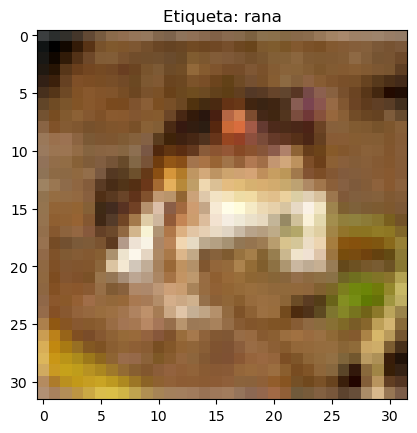

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
clases = ['avion', 'automovil', 'pajaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camion']

print("Cantidad de datos de entrenamiento:", x_train.shape[0])
print("Cantidad de datos de test:", x_test.shape[0])

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

#plor 1
plt.imshow(x_train[0])
plt.title(f"Etiqueta: {clases[y_train[0]]}")
plt.show()

#linealizo las imagenes
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

num_classes = 10

def to_one_hot(y, num_classes=10):
    N = y.shape[0]
    one_hot = np.zeros((N, num_classes), dtype=np.float32)
    one_hot[np.arange(N), y] = 1.0
    return one_hot

y_train_oh = to_one_hot(y_train, num_classes)
y_test_oh  = to_one_hot(y_test, num_classes)

In [4]:
print("Tamaño de x_train después de aplanar:", x_train.shape)


Tamaño de x_train después de aplanar: (50000, 3072)


In [5]:
net = NeuralNet(lr=0.01)
net.add_layer(Dense_Layer(3072, 100, activation='relu'))
net.add_layer(Dense_Layer(100, 10, activation=None))

losses = []
accuracies = []

for epoch in range(100):
    loss = net.train_step(x_train, y_train_oh)
    losses.append(loss)
    acc = net.accuracy(x_train, y_train)
    accuracies.append(acc)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Epoch 0, Loss: 0.3609, Accuracy: 0.0998
Epoch 10, Loss: 0.1006, Accuracy: 0.0953
Epoch 20, Loss: 0.0970, Accuracy: 0.0981
Epoch 30, Loss: 0.0946, Accuracy: 0.1018
Epoch 40, Loss: 0.0928, Accuracy: 0.1066
Epoch 50, Loss: 0.0914, Accuracy: 0.1337
Epoch 60, Loss: 0.0904, Accuracy: 0.1340
Epoch 70, Loss: 0.0897, Accuracy: 0.1409
Epoch 80, Loss: 0.0891, Accuracy: 0.1469
Epoch 90, Loss: 0.0887, Accuracy: 0.1562


# GPU

In [2]:
# Elegimos device
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cpu")

class Dense_Layer():
    def __init__(self, input_size, output_size, activation=None, device=device):
        self.activation = activation
        self.device = device

        # Inicialización tipo He / Xavier según activación
        if activation == 'relu':
            scale = (2.0 / input_size) ** 0.5
        else:
            scale = (1.0 / input_size) ** 0.5

        self.weights = torch.randn(input_size, output_size, device=device) * scale
        self.bias    = torch.zeros(1, output_size, device=device)

        # grad buffers
        self.dW = torch.zeros_like(self.weights)
        self.db = torch.zeros_like(self.bias)

    def _activate(self, z):
        if self.activation == 'relu':
            return torch.clamp(z, min=0.0)
        elif self.activation == 'sigmoid':
            return 1.0 / (1.0 + torch.exp(-z))
        elif self.activation == 'tanh':
            return torch.tanh(z)
        else:
            return z  # identidad / logits

    def _activate_grad(self, z):
        if self.activation == 'relu':
            grad = torch.zeros_like(z)
            grad[z > 0] = 1.0
            return grad
        elif self.activation == 'sigmoid':
            s = 1.0 / (1.0 + torch.exp(-z))
            return s * (1.0 - s)
        elif self.activation == 'tanh':
            t = torch.tanh(z)
            return 1.0 - t**2
        else:
            return torch.ones_like(z)

    def forward(self, x):
        # guardamos para backward
        self.x = x
        self.z = x @ self.weights + self.bias      # (N,in) @ (in,out) -> (N,out)
        self.a = self._activate(self.z)
        return self.a

    def backward(self, dout):
        # chain rule: dL/dz = dL/da * da/dz
        dz = dout * self._activate_grad(self.z)    # (N,out)

        # grad pesos: x^T dz
        self.dW = self.x.T @ dz                    # (in,N)@(N,out)->(in,out)

        # grad bias: sum filas
        self.db = torch.sum(dz, dim=0, keepdim=True)  # (1,out)

        # grad hacia atrás (para capa previa): dz W^T
        dx = dz @ self.weights.T                   # (N,out)@(out,in)->(N,in)
        return dx

    def step(self, lr):
        # actualizamos in-place los parámetros
        self.weights.data -= lr * self.dW
        self.bias.data    -= lr * self.db


class NeuralNet():
    def __init__(self, lr=1e-2, device=device):
        self.List_layers = []
        self.lr = lr
        self.device = device

    def add_layer(self, layer):
        self.List_layers.append(layer)

    def forward(self, x):
        out = x
        for layer in self.List_layers:
            out = layer.forward(out)
        return out

    def backward(self, dloss_dy):
        grad = dloss_dy
        for layer in reversed(self.List_layers):
            grad = layer.backward(grad)

    def step(self):
        for layer in self.List_layers:
            layer.step(self.lr)

    def compute_loss_and_grad(self, y_pred, y_true):
        # y_true debe ser one-hot (N,10)
        N = y_true.shape[0]
        diff = (y_pred - y_true)                # (N,10)
        loss = torch.mean(diff ** 2)            # escalar
        dloss_dy = (2.0 / N) * diff             # (N,10)
        return loss, dloss_dy

    def train_step(self, x_batch, y_batch_onehot):
        y_pred = self.forward(x_batch)                      # (N,10)
        loss, dloss_dy = self.compute_loss_and_grad(y_pred, y_batch_onehot)
        self.backward(dloss_dy)
        self.step()
        return loss.item()  # pasamos a float nativo para imprimir

    def accuracy(self, x, y_true_int):
        y_pred = self.forward(x)                # (N,10)
        y_pred_labels = torch.argmax(y_pred, dim=1)  # (N,)
        return torch.mean((y_pred_labels == y_true_int).float()).item()

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
clases = ['avion', 'automovil', 'pajaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camion']

print("Cantidad de datos de entrenamiento:", x_train.shape[0])
print("Cantidad de datos de test:", x_test.shape[0])

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") 

x_train = torch.tensor(x_train, dtype=torch.float32, device=device).reshape(50000, -1) / 255.0
x_test  = torch.tensor(x_test, dtype=torch.float32, device=device).reshape(10000, -1) / 255.0
y_train = torch.tensor(y_train.flatten(), dtype=torch.long, device=device)
y_test  = torch.tensor(y_test.flatten(), dtype=torch.long, device=device)

# One-hot para el loss MSE:
num_classes = 10
def to_one_hot(y, num_classes=10):
    N = y.shape[0]
    one_hot = torch.zeros(N, num_classes, device=y.device)
    one_hot[torch.arange(N, device=y.device), y] = 1.0
    return one_hot

y_train_oh = to_one_hot(y_train, num_classes)  # (50000,10)

Cantidad de datos de entrenamiento: 50000
Cantidad de datos de test: 10000


In [4]:
# 2. Creamos la red
net = NeuralNet(lr=1e-3, device=device)
net.add_layer(Dense_Layer(3072, 100, activation='relu', device=device))
net.add_layer(Dense_Layer(100, 10, activation=None, device=device))

loss = []
acc = []
acc_test =[]

# 3. Entrenamiento FULL BATCH (didáctico)
for epoch in range(100):
    loss_epoch = net.train_step(x_train, y_train_oh)
    acc_tr = net.accuracy(x_train, y_train)
    acc_te = net.accuracy(x_test, y_test)
    acc.append(acc_tr)
    acc_test.append(acc_te)
    loss.append(loss_epoch)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss={loss_epoch:.4f}, acc={acc_tr:.4f}")

Epoch 0, loss=0.2463, acc=0.0968
Epoch 10, loss=0.1202, acc=0.1088
Epoch 20, loss=0.1151, acc=0.1222
Epoch 30, loss=0.1119, acc=0.1328
Epoch 40, loss=0.1096, acc=0.1409
Epoch 50, loss=0.1077, acc=0.1468
Epoch 60, loss=0.1062, acc=0.1521
Epoch 70, loss=0.1049, acc=0.1563
Epoch 80, loss=0.1038, acc=0.1603
Epoch 90, loss=0.1027, acc=0.1640


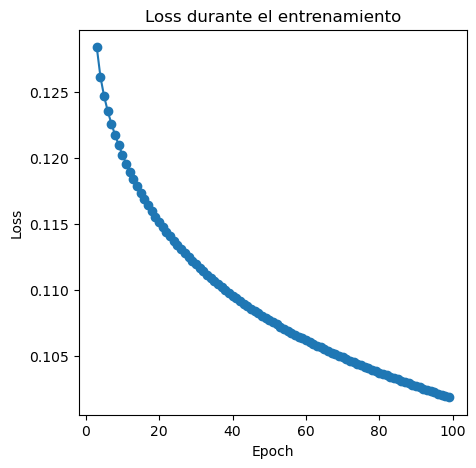

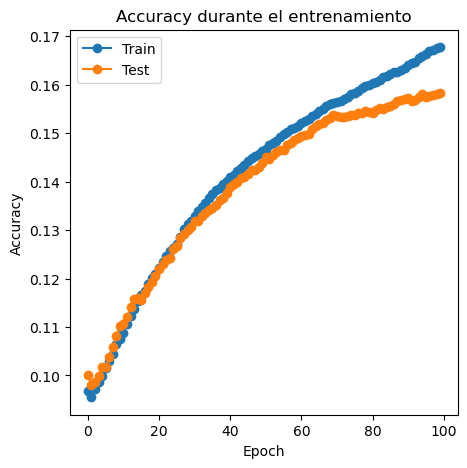

In [7]:
plt.figure(figsize=(5,5))
plt.plot(range(3,len(loss)),loss[3:], "-o")
plt.title("Loss durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.figure(figsize=(5,5))
plt.plot(acc, "-o", label="Train")
plt.plot(acc_test, "-o", label="Test")
plt.title("Accuracy durante el entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()